In [1]:
import json
from matplotlib.font_manager import json_dump
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pylab as plt
import os
  

sf_data = []
vicon_data = []
dataset_name = "run_vertical_4"
path_sf = "/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/sensorfloor_measurement/30092022"
file_name_sf = "sensor_floor_data_30092022_" + dataset_name + ".txt"

os.chdir(path_sf)

#for line in open("../Dataset_sensor_floor/sensorfloor_measurement/16092022/sensor_floor_data_16092022_" + dataset_name + ".txt", "r"):
#for line in open("../../../media/irfan-flw/OS/Arbeit/6GEM/Program_Development/6GEM_Dataset/sensorfloor_measurement/16092022/sensor_floor_data_16092022_" + dataset_name + ".txt", "r"):
for line in open(file_name_sf, "r"):
    sf_data.append(json.loads(line))

df_sf = pd.DataFrame(sf_data)
df_sf

,timestamp,strip_id,node_id,data,column_num
0,1.664545e+09,4,8,"[{'a': [0.062255859375, 0.1513671875, 1.042724...",4
1,1.664545e+09,3,3,"[{'a': [0.049072265625, 0.176025390625, 1.0466...",3
2,1.664545e+09,5,13,"[{'a': [0.056640625, 0.09521484375, 1.00903320...",5
3,1.664545e+09,1,5,"[{'a': [0.001220703125, 0.158935546875, 1.0378...",1
4,1.664545e+09,12,5,"[{'a': [0.027099609375, 0.10400390625, 1.01074...",12
...,...,...,...,...,...
13437,1.664545e+09,13,11,"[{'a': [0.02099609375, 0.077392578125, 0.99145...",13
13438,1.664545e+09,22,11,"[{'a': [0.082763671875, 0.11669921875, 1.02441...",22
13439,1.664545e+09,11,5,"[{'a': [-0.0048828125, 0.16357421875, 1.035400...",11
13440,1.664545e+09,16,11,"[{'a': [0.0341796875, 0.151611328125, 1.008789...",16


## Build the dataframe of sensor floors ##

***Timestamp Interpolation***

In [2]:
# #test timestamp interpolation
# #t_batch_i_now = np.zeros((23,15))
# t_batch_i_old = np.zeros((23,15))
# df_sf_buf = df_sf.copy()


# #df_sf_buf = df_sf_buf.reindex(df_sf_buf.columns.tolist() + ['ax','ay','az','gx','gy','gz','mx','my','mz','rssi'], axis=1) 
# out = []
# for index, row in df_sf_buf.T.items():
#     index_strip_id = int(df_sf_buf['strip_id'][index])
#     index_node_id = int(df_sf_buf['node_id'][index])
#     print('t_batch: ', df_sf_buf['timestamp'][index])
#     #t_batch_i_now[index_strip_id][index_node_id] = df_sf_buf['timestamp'][index]
#     #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
#     delta_t = 0
#     timestamp_i = 0

#     #check timestamp
#     if t_batch_i_old[index_strip_id-1][index_node_id-1] < df_sf_buf['timestamp'][index] and t_batch_i_old[index_strip_id-1][index_node_id-1] > 0:
#         delta_t = (df_sf_buf['timestamp'][index] - t_batch_i_old[index_strip_id-1][index_node_id-1])/len(df_sf_buf['data'][index])
        
#         for i in range(len(df_sf_buf['data'][index])):
#             t_i = t_batch_i_old[index_strip_id-1][index_node_id-1] + ((1+i)*delta_t)
#             if df_sf_buf['data'][index][i]['r'][0] < 0:
#                 #print('iter > 0: ', delta_t)
#                 out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
#                     'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
#                     'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
#                     'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
#                     'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
#             else:
#                 out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
#                     'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
#                     'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
#                     'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
#                     'r':np.nan,'timestamp':t_i})
#             #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
#         # t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]

#     elif t_batch_i_old[index_strip_id-1][index_node_id-1] == 0:
#         delta_t = 4/19
#         #print('iter 0: ', delta_t)
#         for i in range(len(df_sf_buf['data'][index])):
#             t_i = (df_sf_buf['timestamp'][index]-4) + ((1+i)*delta_t)
#             if df_sf_buf['data'][index][i]['r'][0] < 0:
#                 #print(t_i)
#                 out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
#                     'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
#                     'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
#                     'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
#                     'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
#             else:
#                 out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
#                     'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
#                     'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
#                     'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
#                     'r':np.nan,'timestamp':t_i})
#             print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
#         t_first = (df_sf_buf['timestamp'][index]) - 4           
#         t_batch_i_old[index_strip_id-1][index_node_id-1] = t_first
#         #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    
    
#     t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]    
#     #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
        

# df_sf_final = pd.DataFrame(out)
# out.clear()
# df_sf_final

In [3]:
#test timestamp interpolation
#t_batch_i_now = np.zeros((23,15))
t_batch_i_old = np.zeros((23,15))
df_sf_buf = df_sf.copy()


#df_sf_buf = df_sf_buf.reindex(df_sf_buf.columns.tolist() + ['ax','ay','az','gx','gy','gz','mx','my','mz','rssi'], axis=1) 
out = []
for index, row in df_sf_buf.T.items():
    index_strip_id = int(df_sf_buf['strip_id'][index])
    index_node_id = int(df_sf_buf['node_id'][index])
    #print('t_batch: ', df_sf_buf['timestamp'][index])
    #t_batch_i_now[index_strip_id][index_node_id] = df_sf_buf['timestamp'][index]
    #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    delta_t = 0
    timestamp_i = 0

    for i in range(len(df_sf_buf['data'][index])):

        #check timestamp
        if t_batch_i_old[index_strip_id-1][index_node_id-1] < df_sf_buf['timestamp'][index] and t_batch_i_old[index_strip_id-1][index_node_id-1] > 0:
            delta_t = (df_sf_buf['timestamp'][index] - t_batch_i_old[index_strip_id-1][index_node_id-1])/len(df_sf_buf['data'][index])
            
            t_i = t_batch_i_old[index_strip_id-1][index_node_id-1] + ((1+i)*delta_t)
            if df_sf_buf['data'][index][i]['r'][0] < 0:
                #print('iter > 0: ', delta_t)
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
            else:
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':np.nan,'timestamp':t_i})
                #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
            # t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]

        elif t_batch_i_old[index_strip_id-1][index_node_id-1] == 0:
            delta_t = 4/19
            #print('iter 0: ', delta_t)
            t_i = (df_sf_buf['timestamp'][index]-4) + ((1+i)*delta_t)
            if df_sf_buf['data'][index][i]['r'][0] < 0:
                #print(t_i)
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':df_sf_buf['data'][index][i]['r'][0],'timestamp':t_i})
            else:
                out.append({'strip_id':df_sf_buf['strip_id'][index],'node_id':df_sf_buf['node_id'][index],
                    'ax':df_sf_buf['data'][index][i]['a'][0],'ay':df_sf_buf['data'][index][i]['a'][1],'az':df_sf_buf['data'][index][i]['a'][2],
                    'gx':df_sf_buf['data'][index][i]['g'][0],'gy':df_sf_buf['data'][index][i]['g'][1],'gz':df_sf_buf['data'][index][i]['g'][2],
                    'mx':df_sf_buf['data'][index][i]['m'][0],'my':df_sf_buf['data'][index][i]['m'][1],'mz':df_sf_buf['data'][index][i]['m'][2],
                    'r':np.nan,'timestamp':t_i})
            #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
            t_first = (df_sf_buf['timestamp'][index]) - 4           
            t_batch_i_old[index_strip_id-1][index_node_id-1] = t_first
            #print(t_batch_i_old[index_strip_id-1][index_node_id-1])
    
    
    t_batch_i_old[index_strip_id-1][index_node_id-1] = df_sf_buf['timestamp'][index]    
    #print(out[index]['strip_id'], out[index]['node_id'],'t_old: ', t_batch_i_old[index_strip_id-1][index_node_id-1], 't_now: ', df_sf_buf['timestamp'][index], out[index]['timestamp'])
        

df_sf_final = pd.DataFrame(out)
del(out)
df_sf_final

,strip_id,node_id,ax,ay,az,gx,gy,gz,mx,my,mz,r,timestamp
0,4,8,0.062256,0.151367,1.042725,0.160305,1.190840,0.244275,50.70,-44.10,187.05,-78.0,1.664545e+09
1,4,8,0.062744,0.149902,1.036621,0.320611,1.206107,0.351145,51.00,-45.45,186.60,-77.0,1.664545e+09
2,4,8,0.060059,0.145996,1.038574,0.366412,1.213740,0.267176,50.70,-44.70,186.00,-78.0,1.664545e+09
3,4,8,0.060303,0.147217,1.038574,0.511450,1.061069,0.068702,52.50,-42.90,185.70,-77.0,1.664545e+09
4,4,8,0.059570,0.146484,1.039307,0.396947,1.259542,0.167939,51.60,-42.75,185.40,-79.0,1.664545e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254471,3,5,0.065186,0.151367,0.966553,-2.259542,-0.053435,0.404580,-23.10,-6.45,228.00,-78.0,1.664545e+09
254472,3,5,0.066650,0.160400,0.964600,-2.213740,0.030534,0.297710,-24.45,-7.05,229.50,-78.0,1.664545e+09
254473,3,5,0.068359,0.156006,0.968262,-2.000000,0.091603,0.442748,-23.70,-7.35,229.20,-79.0,1.664545e+09
254474,3,5,0.060547,0.151611,0.966064,-2.343511,-0.045802,0.519084,-24.90,-9.00,228.75,-78.0,1.664545e+09


In [4]:
df_sf_final = df_sf_final.sort_values(['timestamp'])
df_sf_final = df_sf_final.reset_index(drop=True)
df_sf_final

,strip_id,node_id,ax,ay,az,gx,gy,gz,mx,my,mz,r,timestamp
0,4,8,0.062256,0.151367,1.042725,0.160305,1.190840,0.244275,50.70,-44.10,187.05,-78.0,1.664545e+09
1,3,3,0.049072,0.176025,1.046631,-0.778626,1.740458,0.114504,111.90,18.45,-154.80,-85.0,1.664545e+09
2,5,13,0.056641,0.095215,1.009033,-2.030534,1.221374,-0.580153,-16.80,5.25,-86.10,-82.0,1.664545e+09
3,1,5,0.001221,0.158936,1.037842,-1.389313,-0.106870,0.229008,111.30,-95.10,40.80,-68.0,1.664545e+09
4,12,5,0.027100,0.104004,1.010742,-3.267176,-0.656489,1.053435,-122.55,106.50,-138.30,-89.0,1.664545e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254471,13,11,0.019775,0.075195,0.993652,0.648855,0.664122,0.007634,13.20,-51.60,194.10,-87.0,1.664545e+09
254472,22,11,0.082275,0.117432,1.016602,-1.717557,0.519084,0.755725,-77.40,-196.05,9.90,-74.0,1.664545e+09
254473,11,5,-0.010498,0.162598,1.032227,-1.236641,0.854962,1.083969,-360.30,8.25,51.00,-88.0,1.664545e+09
254474,16,11,0.030762,0.149658,1.008301,-0.633588,1.572519,0.282443,-14.70,39.45,-94.50,-82.0,1.664545e+09


**Build Dataset of VICON Coordinates**

In [5]:
#DATASET OF VICON COORDINATES
#for line in open("../Dataset_sensor_floor/vicon_measurement/16092022/vicon_data_16092022_" + dataset_name + ".txt", "r"):
path_vicon = "/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/vicon_measurement/30092022"
file_name_vicon = "vicon_data_30092022_" + dataset_name + ".txt"

os.chdir(path_vicon)

for line in open(file_name_vicon, "r"):
    vicon_data.append(json.loads(line))

df_vicon = pd.DataFrame(vicon_data)
#df_vicon['time'] = pd.to_datetime(df_vicon['time'],unit='s')
df_vicon.shape

(18810, 4)

In [6]:
df_vicon_buf = df_vicon.copy()
df_vicon_buf = df_vicon_buf.reindex(df_vicon_buf.columns.tolist() + ['X','Y'], axis=1) 

for index, row in df_vicon_buf.T.items():
    for i in range(len(df_vicon_buf['translation'][index])):
        #print((test_df['data'][index][i]['r']))
        df_vicon_buf.loc[index,'X'] = df_vicon_buf['translation'][index][0]
        df_vicon_buf.loc[index,'Y'] = df_vicon_buf['translation'][index][1]

df_vicon_buf = df_vicon_buf.drop(columns=['object','translation','rotation'])
#df_vicon_buf

***Filter and Resample Vicon Data***

In [7]:
df_vicon_resample = df_vicon_buf.copy()
df_vicon_resample['time_resample'] = pd.to_datetime(df_vicon_resample['time'],unit='s')
#df_vicon_resample['time'] = df_vicon_resample['time'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f'))
df_vicon_resample = df_vicon_resample.set_index('time_resample')
df_vicon_final = df_vicon_resample.resample('60ms').ffill()
df_vicon_final = df_vicon_final.dropna()
df_vicon_final = df_vicon_final.sort_values(['time'])
df_vicon_final = df_vicon_final.reset_index(drop=True)
df_vicon_final

,time,X,Y
0,1.664545e+09,-10.820423,4.541924
1,1.664545e+09,-10.820467,4.541971
2,1.664545e+09,-10.820456,4.541942
3,1.664545e+09,-10.820433,4.542002
4,1.664545e+09,-10.820434,4.541925
...,...,...,...
2852,1.664545e+09,8.586549,-4.039400
2853,1.664545e+09,8.586524,-4.039318
2854,1.664545e+09,8.586518,-4.039343
2855,1.664545e+09,8.586516,-4.039394


**MERGE RSSI HEATMAP & VICON COORDINATES WITH ANIMATION**

In [8]:
# #MERGE RSSI HEATMAP & VICON COORDINATES WITH ANIMATION

# #Heatmap animation over the time
# from turtle import width
# import matplotlib.animation as animation
# %matplotlib ipympl
# from matplotlib.widgets import Slider, Button, RadioButtons
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# #DEFINE DATASET ARRAY
# x_sf = df_sf_filter['strip_id'].to_numpy()
# y_sf = df_sf_filter['node_id'].to_numpy()
# z_sf = df_sf_filter['rssi'].to_numpy()
# t_sf = df_sf_filter['timestamp'].to_numpy()
# dataSet_sf = np.array([x_sf, y_sf, z_sf, t_sf])
# numDataPoints_sf = len(t_sf)
# num_of_nodes = 15
# num_of_strips = 23


# #CREATE 3D ARRAY FOR HEATMAP
# rssi_mat = np.empty((numDataPoints_sf,15,23))
# timestamp_arr = np.empty((numDataPoints_sf,15,23))
# fig = plt.figure(figsize=(15, 9))

# for index in range(numDataPoints_sf):
#     for node in range(num_of_nodes):
#         for strip in range(num_of_strips):
#             if node == int(dataSet_sf[1][index])-1 and strip == int(dataSet_sf[0][index])-1:
#                 rssi_mat[index][int(dataSet_sf[1][index])-1][int(dataSet_sf[0][index])-1] = (dataSet_sf[2][index])
#                 timestamp_arr[index][int(dataSet_sf[1][index])-1][int(dataSet_sf[0][index])-1] = (dataSet_sf[3][index])
#             else:
#                 rssi_mat[index][node][strip] = rssi_mat[index-1][node][strip]
#                 timestamp_arr[index][node][strip] = timestamp_arr[index-1][node][strip]


# numDataPoints_sf = dataSet_sf.shape[1]

# delta_t_sf = round((t_sf.max()-t_sf.min())/numDataPoints_sf, 6)

# #-------------------------------------------------------------------------------------------------------------------#

# #CREATE DATASET FOR VICON COORDINATES
# t_vc = df_vicon_filter['time'].to_numpy()
# x_vc = df_vicon_filter['X'].to_numpy()
# y_vc = df_vicon_filter['Y'].to_numpy()
# dataSet_vc = np.array([x_vc, y_vc, t_vc])
# numDataPoints_vc = len(t_vc)


# numDataPoints_vc = dataSet_vc.shape[1]

# delta_t_vc = round((t_vc.max()-t_vc.min())/numDataPoints_vc, 6)
# #-------------------------------------------------------------------------------------------------------------------#

# # GET SOME MATPLOTLIB OBJECTS
# #fig, (ax1, ax2) = plt.subplots(figsize=(10,12), nrows=2)
# fig = plt.figure(figsize=(12,14))
# #plt.subplots_adjust(bottom=0.25)


# # AXES PROPERTIES RSSI HEATMAP
# ax1 = fig.add_subplot(211) #(row, column, pos)
# #ax1.set_autoscale_on
# ax1.set_xlabel('Strip ID')
# ax1.set_ylabel('Node ID')
# ax1.set_title('RSSI Heatmap')

# # # AXES PROPERTIES VICON COORDINATES
# ax2 = fig.add_subplot(212)
# ax2.set_xlim(-11.185, 10.185)
# ax2.set_ylim(-6.425, 7.575)
# ax2.set_xlabel('X(t)')
# ax2.set_ylabel('Y(t)')
# ax2.set_title('Trajectory of robot')


# #DISPLAY INITIAL IMAGE
# im_h = ax1.imshow(rssi_mat[numDataPoints_sf-1], cmap="YlGnBu", aspect='auto')
# axins = inset_axes(ax1,
#                    width="1%",  # width = 5% of parent_bbox width
#                    height="90%",  # height : 50%
#                    loc='lower left',
#                    bbox_to_anchor=(1.05, 1.25, 1, 1),
#                    bbox_transform=ax2.transAxes,
#                    borderpad=0,
#                    )
# cbar = plt.colorbar(im_h, cax=axins, ax=ax1)
# cbar.set_label(label='RSSI (dBm)', size=15)
# cbar.ax.tick_params(labelsize=12)

# line = ax2.plot(dataSet_vc[0], dataSet_vc[1], lw=2, c='g')[0] # For line plot


# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

# def animate(num, rssi_mat, line, dataSet_sf, dataSet_vc):
#     line.set_xdata(dataSet_vc[0, :num])
#     line.set_ydata(dataSet_vc[1, :num])
#     index_rssi = find_nearest(dataSet_sf[3], dataSet_vc[2,num])
#     im_h.set_data(rssi_mat[index_rssi]) 
#     return line

# plt.subplots_adjust(left=0.1, bottom=0.2, right=0.88, top=0.97, hspace=0.2)
# anim = animation.FuncAnimation(fig, animate, frames=numDataPoints_vc, fargs=(rssi_mat, line, dataSet_sf, dataSet_vc), interval=1, repeat=False, blit=False)
# # anim.save(r'Animation_Move_Around4_17082022.mp4')

# plt.show()

**MERGE RSSI HEATMAP & VICON COORDINATES WITH SLIDER**

dataset vc old: (3, 2857)


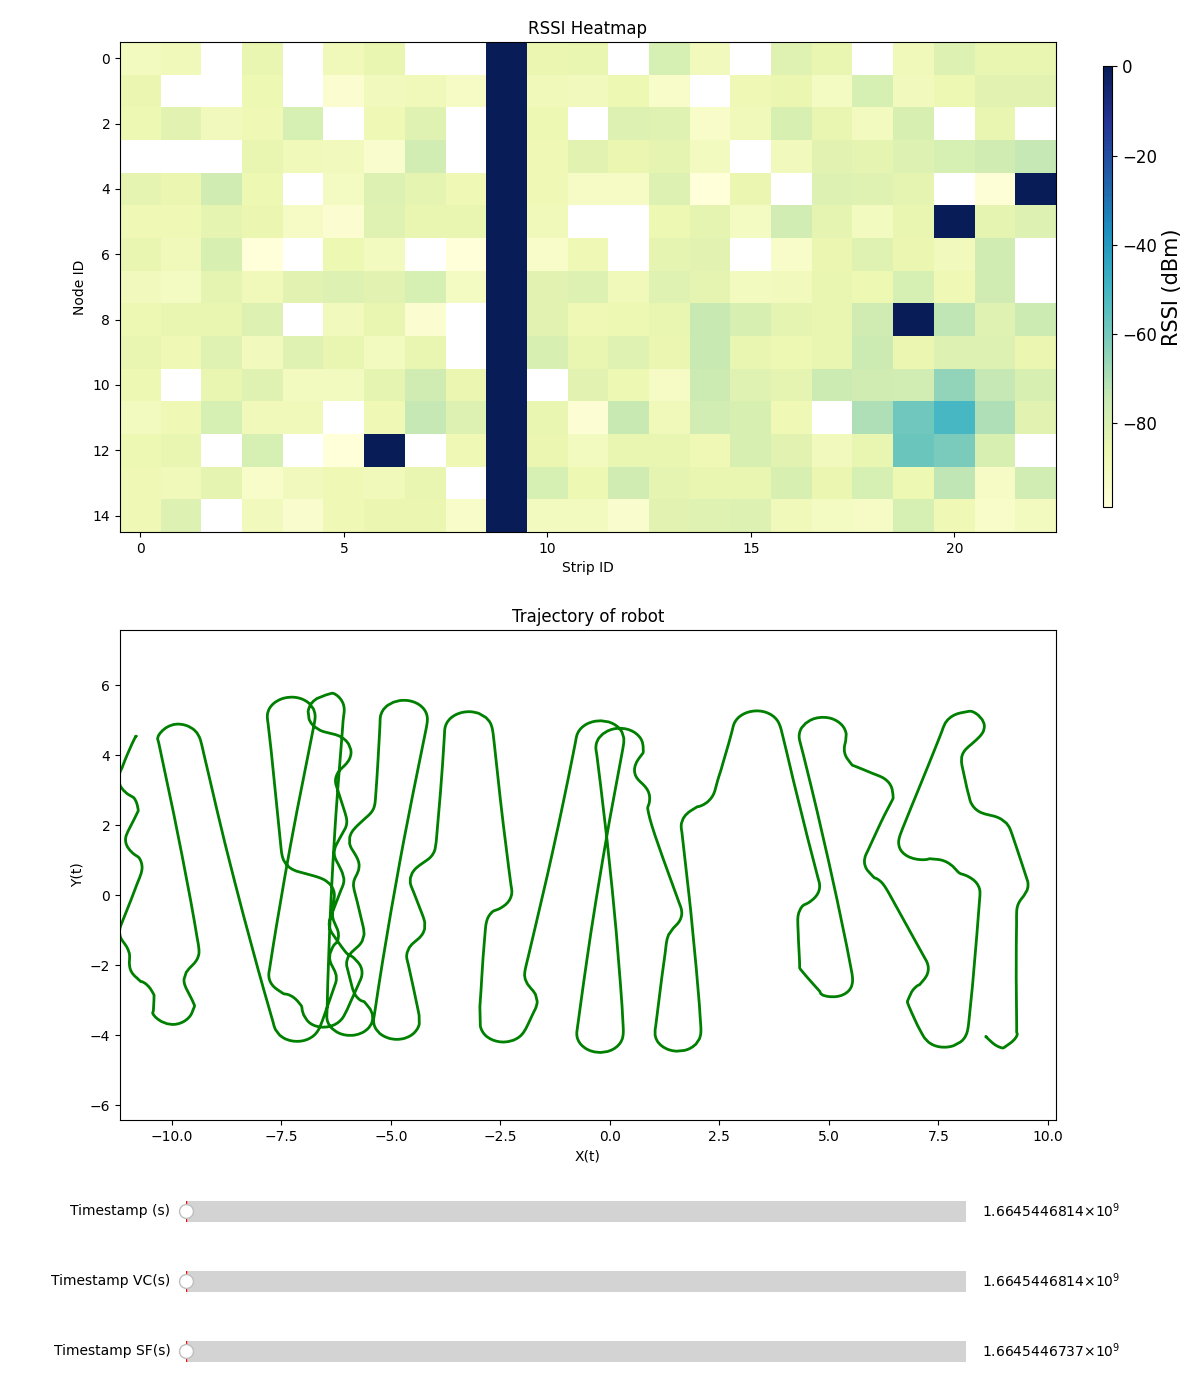

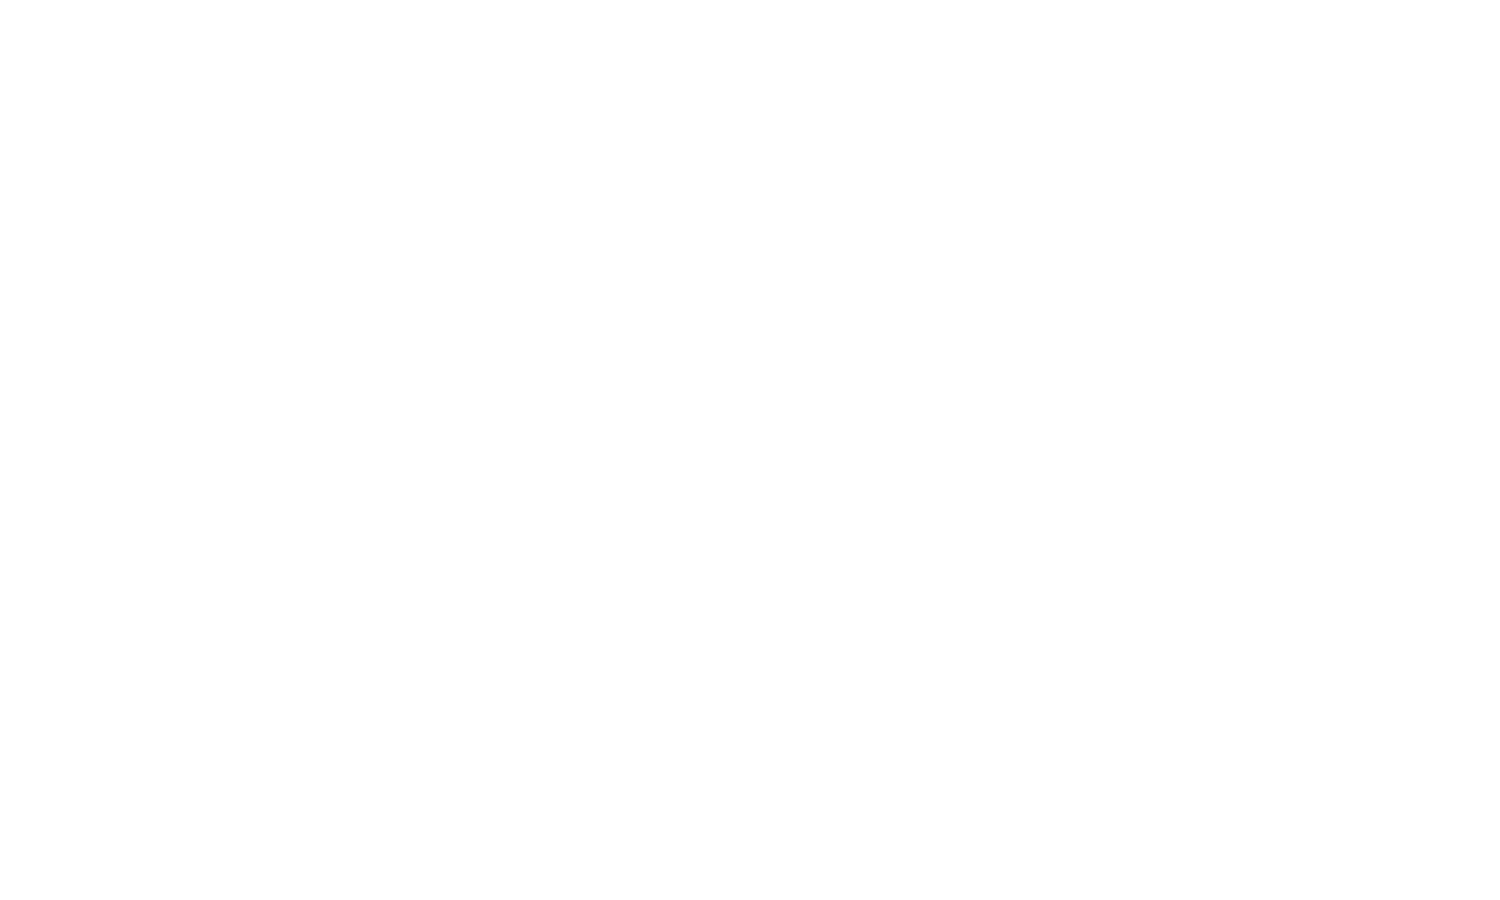

In [9]:
#MERGE RSSI HEATMAP & VICON COORDINATES WITH SLIDER

#Heatmap animation over the time
from turtle import width
import matplotlib.animation as animation
%matplotlib ipympl
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#DEFINE DATASET ARRAY
x_sf = df_sf_final['strip_id'].to_numpy()
y_sf = df_sf_final['node_id'].to_numpy()
z_sf = df_sf_final['r'].to_numpy()
t_sf = df_sf_final['timestamp'].to_numpy()
dataSet_sf = np.array([x_sf, y_sf, z_sf, t_sf])
numDataPoints_sf = len(t_sf)
num_of_nodes = 15
num_of_strips = 23


#CREATE 3D ARRAY FOR HEATMAP
rssi_mat = np.empty((numDataPoints_sf,15,23))
timestamp_arr = np.empty((numDataPoints_sf,15,23))
fig = plt.figure(figsize=(15, 9))

for index in range(numDataPoints_sf):
    for node in range(num_of_nodes):
        for strip in range(num_of_strips):
            if node == int(dataSet_sf[1][index])-1 and strip == int(dataSet_sf[0][index])-1:
                rssi_mat[index][int(dataSet_sf[1][index])-1][int(dataSet_sf[0][index])-1] = (dataSet_sf[2][index])
                timestamp_arr[index][int(dataSet_sf[1][index])-1][int(dataSet_sf[0][index])-1] = (dataSet_sf[3][index])
            else:
                rssi_mat[index][node][strip] = rssi_mat[index-1][node][strip]
                timestamp_arr[index][node][strip] = timestamp_arr[index-1][node][strip]


numDataPoints_sf = dataSet_sf.shape[1]
# print("dataset sf:",dataSet_sf.shape, "rssi new: ", rssi_mat.shape)
# print(dataSet_sf)

delta_t_sf = round((t_sf.max()-t_sf.min())/numDataPoints_sf, 6)

#print("new t_sf:", t_sf, t_sf.shape, "x_sf:", x_sf.shape, "y_sf:", y_sf.shape, "z_sf:", z_sf.shape)

#-------------------------------------------------------------------------------------------------------------------#

#CREATE DATASET FOR VICON COORDINATES
t_vc = df_vicon_final['time'].to_numpy()
x_vc = df_vicon_final['X'].to_numpy()
y_vc = df_vicon_final['Y'].to_numpy()
dataSet_vc = np.array([x_vc, y_vc, t_vc])
numDataPoints_vc = len(t_vc)

print("dataset vc old:", dataSet_vc.shape)

numDataPoints_vc = dataSet_vc.shape[1]
# print("dataset vc:",dataSet_vc.shape)
# print(dataSet_vc)

delta_t_vc = round((t_vc.max()-t_vc.min())/numDataPoints_vc, 6)
#-------------------------------------------------------------------------------------------------------------------#

# GET SOME MATPLOTLIB OBJECTS
#fig, (ax1, ax2) = plt.subplots(figsize=(10,12), nrows=2)
fig = plt.figure(figsize=(12,14))
plt.subplots_adjust(bottom=0.25)


# AXES PROPERTIES RSSI HEATMAP
ax1 = fig.add_subplot(211) #(row, column, pos)
#ax1.set_autoscale_on
ax1.set_xlabel('Strip ID')
ax1.set_ylabel('Node ID')
ax1.set_title('RSSI Heatmap')

# # AXES PROPERTIES VICON COORDINATES
ax2 = fig.add_subplot(212)
ax2.set_xlim(-11.185, 10.185)
ax2.set_ylim(-6.425, 7.575)
ax2.set_xlabel('X(t)')
ax2.set_ylabel('Y(t)')
ax2.set_title('Trajectory of robot')


# Defining the Slider button
# xposition, yposition, width and height
ax_slide_sf = plt.axes([0.155, 0.02, 0.65, 0.03])
ax_slide_vc = plt.axes([0.155, 0.07, 0.65, 0.03])
ax_slide_merge = plt.axes([0.155, 0.12, 0.65, 0.03])


#DISPLAY INITIAL IMAGE
im_h = ax1.imshow(rssi_mat[numDataPoints_sf-1], cmap="YlGnBu", aspect='auto')
axins = inset_axes(ax1,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 1.25, 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
cbar = plt.colorbar(im_h, cax=axins, ax=ax1)
cbar.set_label(label='RSSI (dBm)', size=15)
cbar.ax.tick_params(labelsize=12)


#cbar.ax.set_axes_locator
# #cbar.set_ticks()

line = ax2.plot(dataSet_vc[0], dataSet_vc[1], lw=2, c='g')[0] # For line plot


# Properties of the slider

#normal data
timestamp_rssi = Slider(ax_slide_sf, 'Timestamp SF(s)',
                  t_sf.min(), t_sf.max(), valinit=t_sf.min(), valstep=delta_t_sf)
timestamp_vc = Slider(ax_slide_vc, 'Timestamp VC(s)',
                  t_vc.min(), t_vc.max(), valinit=t_vc.min(), valstep=delta_t_vc)
timestamp_merge = Slider(ax_slide_merge, 'Timestamp (s)',
                  t_vc.min(), t_vc.max(), valinit=t_vc.min(), valstep=delta_t_vc)


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def update_heatmap(val):
    pos = timestamp_rssi.val
    index = find_nearest(dataSet_sf[3], pos)
    im_h.set_data(rssi_mat[index])

def update_coord(val):
    pos = timestamp_vc.val
    index = find_nearest(dataSet_vc[2], pos)
    line.set_xdata(dataSet_vc[0, :index])
    line.set_ydata(dataSet_vc[1, :index])

    #redrawing the figure
    fig.canvas.draw()    

def update_all(val):
    pos = timestamp_merge.val
    #print(pos)
    index = find_nearest(dataSet_vc[2], pos)
    line.set_xdata(dataSet_vc[0, :index])
    line.set_ydata(dataSet_vc[1, :index])

    index2 = find_nearest(dataSet_sf[3], dataSet_vc[2][index])
    im_h.set_data(rssi_mat[index2])

    #redrawing the figure
    fig.canvas.draw() 

# Calling the function "update" when the value of the slider is changed
timestamp_rssi.on_changed(update_heatmap)
timestamp_vc.on_changed(update_coord)
timestamp_merge.on_changed(update_all)

#fig.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.88, top=0.97, hspace=0.2)
#plt.subplots_adjust(left=0.155, bottom=0.2, right=0.91, top=0.97, hspace=0.2)
#plt.subplot_tool()
plt.show()

In [10]:
home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/output/plot_img'
os.chdir(home_path)
plt.savefig(dataset_name + '.png', dpi=300)

**Check the index of closest timestamp to Vicon Dataset**

In [11]:
threshold_sf_up = 1663337798.499045
threshold_sf_low = 1664539045.1935768
filter_dataset = False

#run horizontal 1 low: 1664539382.492
#run diagonal 1 low: 1664537534.7823327
#run diagonal 3 low: 1664543769.535733
#run vertical 3 low: 1664539045.1935768

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print(np.abs(array - value), len(np.abs(array - value)))
    return idx

timestamp_merge_arr = [t_vc[idx]+delta_t_vc for idx, x in enumerate(t_vc)]
index_low_vc = find_nearest(dataSet_vc[2], threshold_sf_low)
index_low_X = find_nearest(dataSet_sf[3], dataSet_vc[2][index_low_vc])
#timestamp_merge_arr_filter = [t_vc[idx]+delta_t_vc for idx, x in enumerate(t_vc) if idx > index_low_vc-1]

#print(index_vicon, index_sf)
closest_index_vicon = []
#closest_time_vicon = [] 
closest_index_sf = []
#closest_time_sf = [] 

#for i in range(len(timestamp_merge_arr_filter)):

for i in range(len(timestamp_merge_arr)):

    pos = timestamp_merge_arr[i]
    #pos = timestamp_merge_arr_filter[i]
    index_vicon = find_nearest(dataSet_vc[2], pos)
    index_sf = find_nearest(dataSet_sf[3], dataSet_vc[2][index_vicon])

    if index_vicon > index_low_vc-1 and filter_dataset:
        #print("filter")
        closest_index_vicon.append(index_vicon)
        closest_index_sf.append(index_sf)
    elif filter_dataset == False:
        #print("not filter")
        closest_index_vicon.append(index_vicon)
        closest_index_sf.append(index_sf)

print(len(closest_index_sf), len(closest_index_vicon))

2857 2857


**CREATE FRAME FOR MERGED DATASET**

In [12]:
#CREATE ARRAY FOR DATA SENSORS
#from asyncio.windows_events import NULL
from tqdm import tqdm_notebook as tqdm


path = "/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter"

os.chdir(path)

KEYS = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']
Vicon_Coords = pd.read_csv("vicon_node_positions.csv")
df_data = Vicon_Coords[['strip_id','node_id']]
df_data = df_data.astype('int32')

X = np.zeros([len(closest_index_sf), 23, 15, 11])
t = np.zeros([len(closest_index_sf), 1])
frames = []
#frames = ["" for x in range(len(closest_index_sf))]
dataSet_vc_X = []
dataSet_vc_Y = []
dataSet_vc_t = []
cnt = 0

X_i = np.zeros([23, 15, 11])
#df_sf_final
#for index, row in tqdm(df_sf_assoc.T.items(), total=len(df_sf_assoc)):
for index, row in tqdm(df_sf_final.T.items(), total=len(df_sf_final)):
#for index, row in df_sf_assoc.T.items():

    df_i = row

    for i, key in enumerate(KEYS):
        X_i[int(df_i.strip_id) - 1, int(df_i.node_id) - 1, i] = df_i[key]
    
    X_df = X_i.reshape([345,11])
    df_X = pd.DataFrame(X_df, columns=KEYS)
    df_data[['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'r', 'timestamp']] = df_X
    frame_i = df_data.to_json(orient='columns')
    
    t_i = df_i.timestamp

    # X[index] = X_i
    # t[index] = t_i
    #frames.insert(index, frame_i)
    frame_bool = df_data.empty
    #print(frame_bool)

    if index in closest_index_sf and not frame_bool:
       
        #print(df_data)
        index_assoc = closest_index_sf.index(index)
        #print(cnt, index, index_assoc)
        frames.append(frame_i)
        #frames[cnt] = frame_i
        X[cnt] = X_i
        t[cnt] = t_i
        dataSet_vc_X.append(dataSet_vc[0,index_assoc])
        dataSet_vc_Y.append(dataSet_vc[1,index_assoc])
        dataSet_vc_t.append(dataSet_vc[2,index_assoc])
        #dataSet_vc_final.append(dataSet_vc[:,index_assoc])
        #print(dataSet_vc[0,index_assoc],dataSet_vc[1,index_assoc],dataSet_vc[2,index_assoc])

        # frames[index_assoc] = frame_i
        # X[index_assoc] = X_i
        # t[index_assoc] = t_i
        cnt += 1
    #print(index,'/',len(df_sf_final))

dataSet_vc_final = np.array([dataSet_vc_X, dataSet_vc_Y, dataSet_vc_t])
print(X.shape, t.shape, len(frames), dataSet_vc_final.shape)

/tmp/ipykernel_9193/3495301189.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm(df_sf_final.T.items(), total=len(df_sf_final)):


  0%|          | 0/254476 [00:00<?, ?it/s]

(2857, 23, 15, 11) (2857, 1) 2850 (3, 2850)


In [16]:
# threshold_sf_low = 1664539045.1935768
# index_low_vc = find_nearest(dataSet_vc[2], threshold_sf_low)
# index_low_X = find_nearest(dataSet_sf[3], dataSet_vc[2][index_low_vc]) 
# print(index_low_X, index_low_vc)

4989 126


**Check index of timestamp threshold**

In [13]:
#Filter out the array - Uncomment if necessary

# def closest_timestamp(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx


# index_low_vc = closest_timestamp(dataSet_vc[2], threshold_sf_low)
# index_low_X = closest_timestamp(dataSet_sf[3], dataSet_vc[2][index_low_vc]) 
# # index_up_X = closest_timestamp(t_data, threshold_sf_up)
# # index_up_vc = closest_timestamp(dataSet_vc[2], threshold_sf_up)

# print(index_low_X, index_low_vc)

# sensor_data_final = X[index_low_X:]
# t_data_final = t[index_low_X:]
# frames_final = frames[index_low_X:]
# dataSet_vc_final = dataSet_vc[:,index_low_vc-1:]
# dataSet_vc_final = np.transpose(dataSet_vc_final)

sensor_data_final = X[:cnt-1]
t_data_final = t[:cnt-1]
frames_final = frames[:cnt-1]

#dataSet_vc_final = dataSet_vc[:,:]
dataSet_vc_final = dataSet_vc_final[:,:-1]
dataSet_vc_final = np.transpose(dataSet_vc_final)

#print(index_low_X, t[index_low_X] , index_low_vc, dataSet_vc[2][index_low_vc])
print(sensor_data_final.shape, t_data_final.shape, len(frames_final), dataSet_vc_final.shape)

(2849, 23, 15, 11) (2849, 1) 2849 (2849, 3)


In [14]:
#MERGE DATASET

#dataSet_vc_final = np.transpose(dataSet_vc_final)
frame_number = np.empty(dataSet_vc_final.shape[0], dtype=object)
frame_data = np.empty(dataSet_vc_final.shape[0], dtype=object)
frame_count = 0
for row in range(dataSet_vc_final.shape[0]):
    time_vc = dataSet_vc_final[row][2]
    #time_vc = dataSet_vc[2][row]
    #index_vc = closest_timestamp(dataSet_vc[2], time_vc)
    #index_sf = closest_timestamp(t_data_final, time_vc)

    frame_number[row] = str(frame_count)
    frame_data[row] = frames_final[row]
    frame_count += 1

**GENERATES THE DATASET AS .CSV FILE**

In [15]:
array_frame_vc = dataSet_vc_final.astype(object)

dataSet_final = np.array([frame_number, array_frame_vc[:,0], array_frame_vc[:,1], frame_data])
dataSet_final = np.transpose(dataSet_final)
#dataSet_final.shape
frame_sf = pd.DataFrame(dataSet_final, columns=['frame_number','vicon_x','vicon_y','data'])

path_dataset = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/30092022/'

os.chdir(path_dataset)

frame_sf.to_csv(r'/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/30092022/' +  dataset_name + '.csv', index=False)

#data_dir = '../Dataset_sensor_floor/Dataset_Final/30092022/'
#csv_name = data_dir + 'dataset_3009022_' + dataset_name + '.csv'
# csv_name = path_dataset + dataset_name + '.csv'
# frame_sf.to_csv(csv_name, index=False)
#dataSet_final